In [1]:
import numpy as np
import pandas as pd

import os.path as op
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from captum.attr import IntegratedGradients, GuidedGradCam
from matplotlib import pyplot as plt

torch.manual_seed(42)

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}  

In [2]:
year = 2017
images = np.memmap(op.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))

In [3]:
label_df = pd.read_feather(op.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather"))
assert(len(label_df) == len(images))
label_df.head()

,Date,StockID,MarketCap,Ret_5d,Ret_20d,Ret_60d,Ret_month,EWMA_vol
0,2017-01-31,10001,133078.0,4.370390e-07,-0.000002,-0.005954,-0.000002,0.000450
1,2017-02-28,10001,133078.0,3.951997e-03,0.002795,0.009953,0.009953,0.000180
2,2017-03-31,10001,133604.0,-7.874612e-03,-0.015749,0.021723,-0.015749,0.000064
3,2017-04-28,10001,131500.0,9.999880e-03,0.016001,0.038072,0.016001,0.000030
4,2017-05-31,10001,133604.0,4.370390e-07,0.021722,NaN,0.023703,0.000015


In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(46080, 2),
        )
        self.softmax = nn.Softmax(dim=1)
       
    def forward(self, x):
        x = x.reshape(-1,1,64,60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(-1,46080)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

In [5]:
net = torch.load('/home/clidg/proj_2/pt/baseline_epoch_10_train_0.688653_eval_0.686537_.pt')

In [6]:
net.eval()

DataParallel(
  (module): Net(
    (layer1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (layer3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Le

In [33]:
x = torch.Tensor(images[42].copy())
x = x.reshape(-1,1,64,60)
x.requires_grad = True
baseline = torch.zeros_like(x)

In [34]:
ig = IntegratedGradients(net)
attributions, delta = ig.attribute(x.cuda(), baseline.cuda(), target=0, return_convergence_delta=True)
print('IG Attributions:', attributions)
print('Convergence Delta:', delta)

IG Attributions: tensor([[[[ 0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
           -0.0000e+00,  0.0000e+00],
          [-0.0000e+00, -5.4040e-04, -0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  6.2465e-03,  0.0000e+00,  ..., -0.0000e+00,
           -0.0000e+00,  0.0000e+00],
          ...,
          [-0.0000e+00,  6.1586e-03, -0.0000e+00,  ..., -0.0000e+00,
           -2.2493e-02, -0.0000e+00],
          [ 0.0000e+00,  1.8688e-02, -0.0000e+00,  ...,  0.0000e+00,
           -6.3821e-02, -0.0000e+00],
          [-0.0000e+00,  8.7603e-05, -0.0000e+00,  ..., -0.0000e+00,
            4.0187e-03, -0.0000e+00]]]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
Convergence Delta: tensor([0.0042], device='cuda:0', dtype=torch.float64)


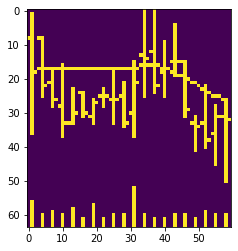

In [36]:
plt.imshow(x[0,0].detach().cpu().numpy())

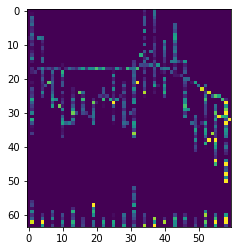

In [37]:
plt.imshow(abs(attributions.detach().cpu().numpy()[0,0]),vmin=0,vmax=0.02)

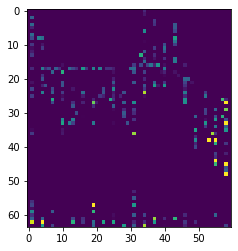

In [38]:
plt.imshow(attributions.detach().cpu().numpy()[0,0],vmin=0,vmax=0.02)

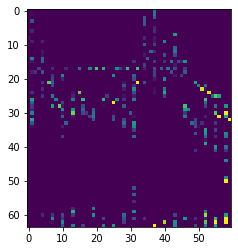

In [39]:
plt.imshow(-attributions.detach().cpu().numpy()[0,0],vmin=0,vmax=0.02)

In [60]:
cam_layer_1 = GuidedGradCam(net, net.module.layer1)
attributions_layer_1 = cam_layer_1.attribute(x.cuda(), target=1)
cam_layer_2 = GuidedGradCam(net, net.module.layer2)
attributions_layer_2 = cam_layer_2.attribute(x.cuda(), target=1)
cam_layer_3 = GuidedGradCam(net, net.module.layer3)
attributions_layer_3 = cam_layer_3.attribute(x.cuda(), target=1)

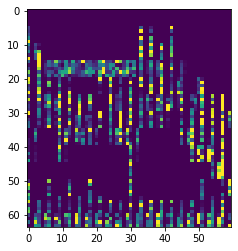

In [69]:
plt.imshow(abs(attributions_layer_1.detach().cpu().numpy()[0,0]), vmax=1e-8)

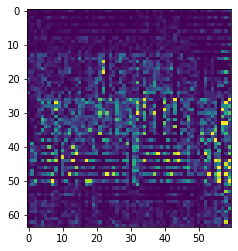

In [70]:
plt.imshow(abs(attributions_layer_2.detach().cpu().numpy()[0,0]), vmax=1e-7)

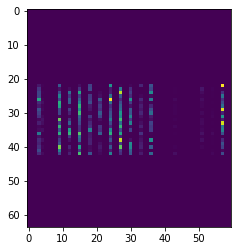

In [68]:
plt.imshow(abs(attributions_layer_3.detach().cpu().numpy()[0,0]), vmax=1e-7)